In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SimpleRNN/GOOG (4).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-18,53.092999,53.497002,53.034000,53.318001,53.318001,31304000
1,2018-05-21,53.702999,54.400002,53.682499,53.979000,53.979000,20464000
2,2018-05-22,54.178001,54.329498,53.334499,53.486500,53.486500,21800000
3,2018-05-23,53.256500,54.039001,53.085499,53.984501,53.984501,21214000
4,2018-05-24,53.950001,54.023499,53.307499,53.962002,53.962002,15336000
...,...,...,...,...,...,...,...
1255,2023-05-15,116.489998,118.794998,116.480003,116.959999,116.959999,22107900
1256,2023-05-16,116.830002,121.199997,116.830002,120.089996,120.089996,32370100
1257,2023-05-17,120.180000,122.279999,119.459999,121.480003,121.480003,26659600
1258,2023-05-18,121.559998,123.900002,121.489998,123.519997,123.519997,27014500


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [ ]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2018-05-18,53.318001
1,2018-05-21,53.979000
2,2018-05-22,53.486500
3,2018-05-23,53.984501
4,2018-05-24,53.962002


In [ ]:
new_df.describe()

,Close
count,1260.000000
mean,89.516771
std,30.150199
min,48.811001
25%,60.555250
50%,86.767250
75%,114.176250
max,150.709000


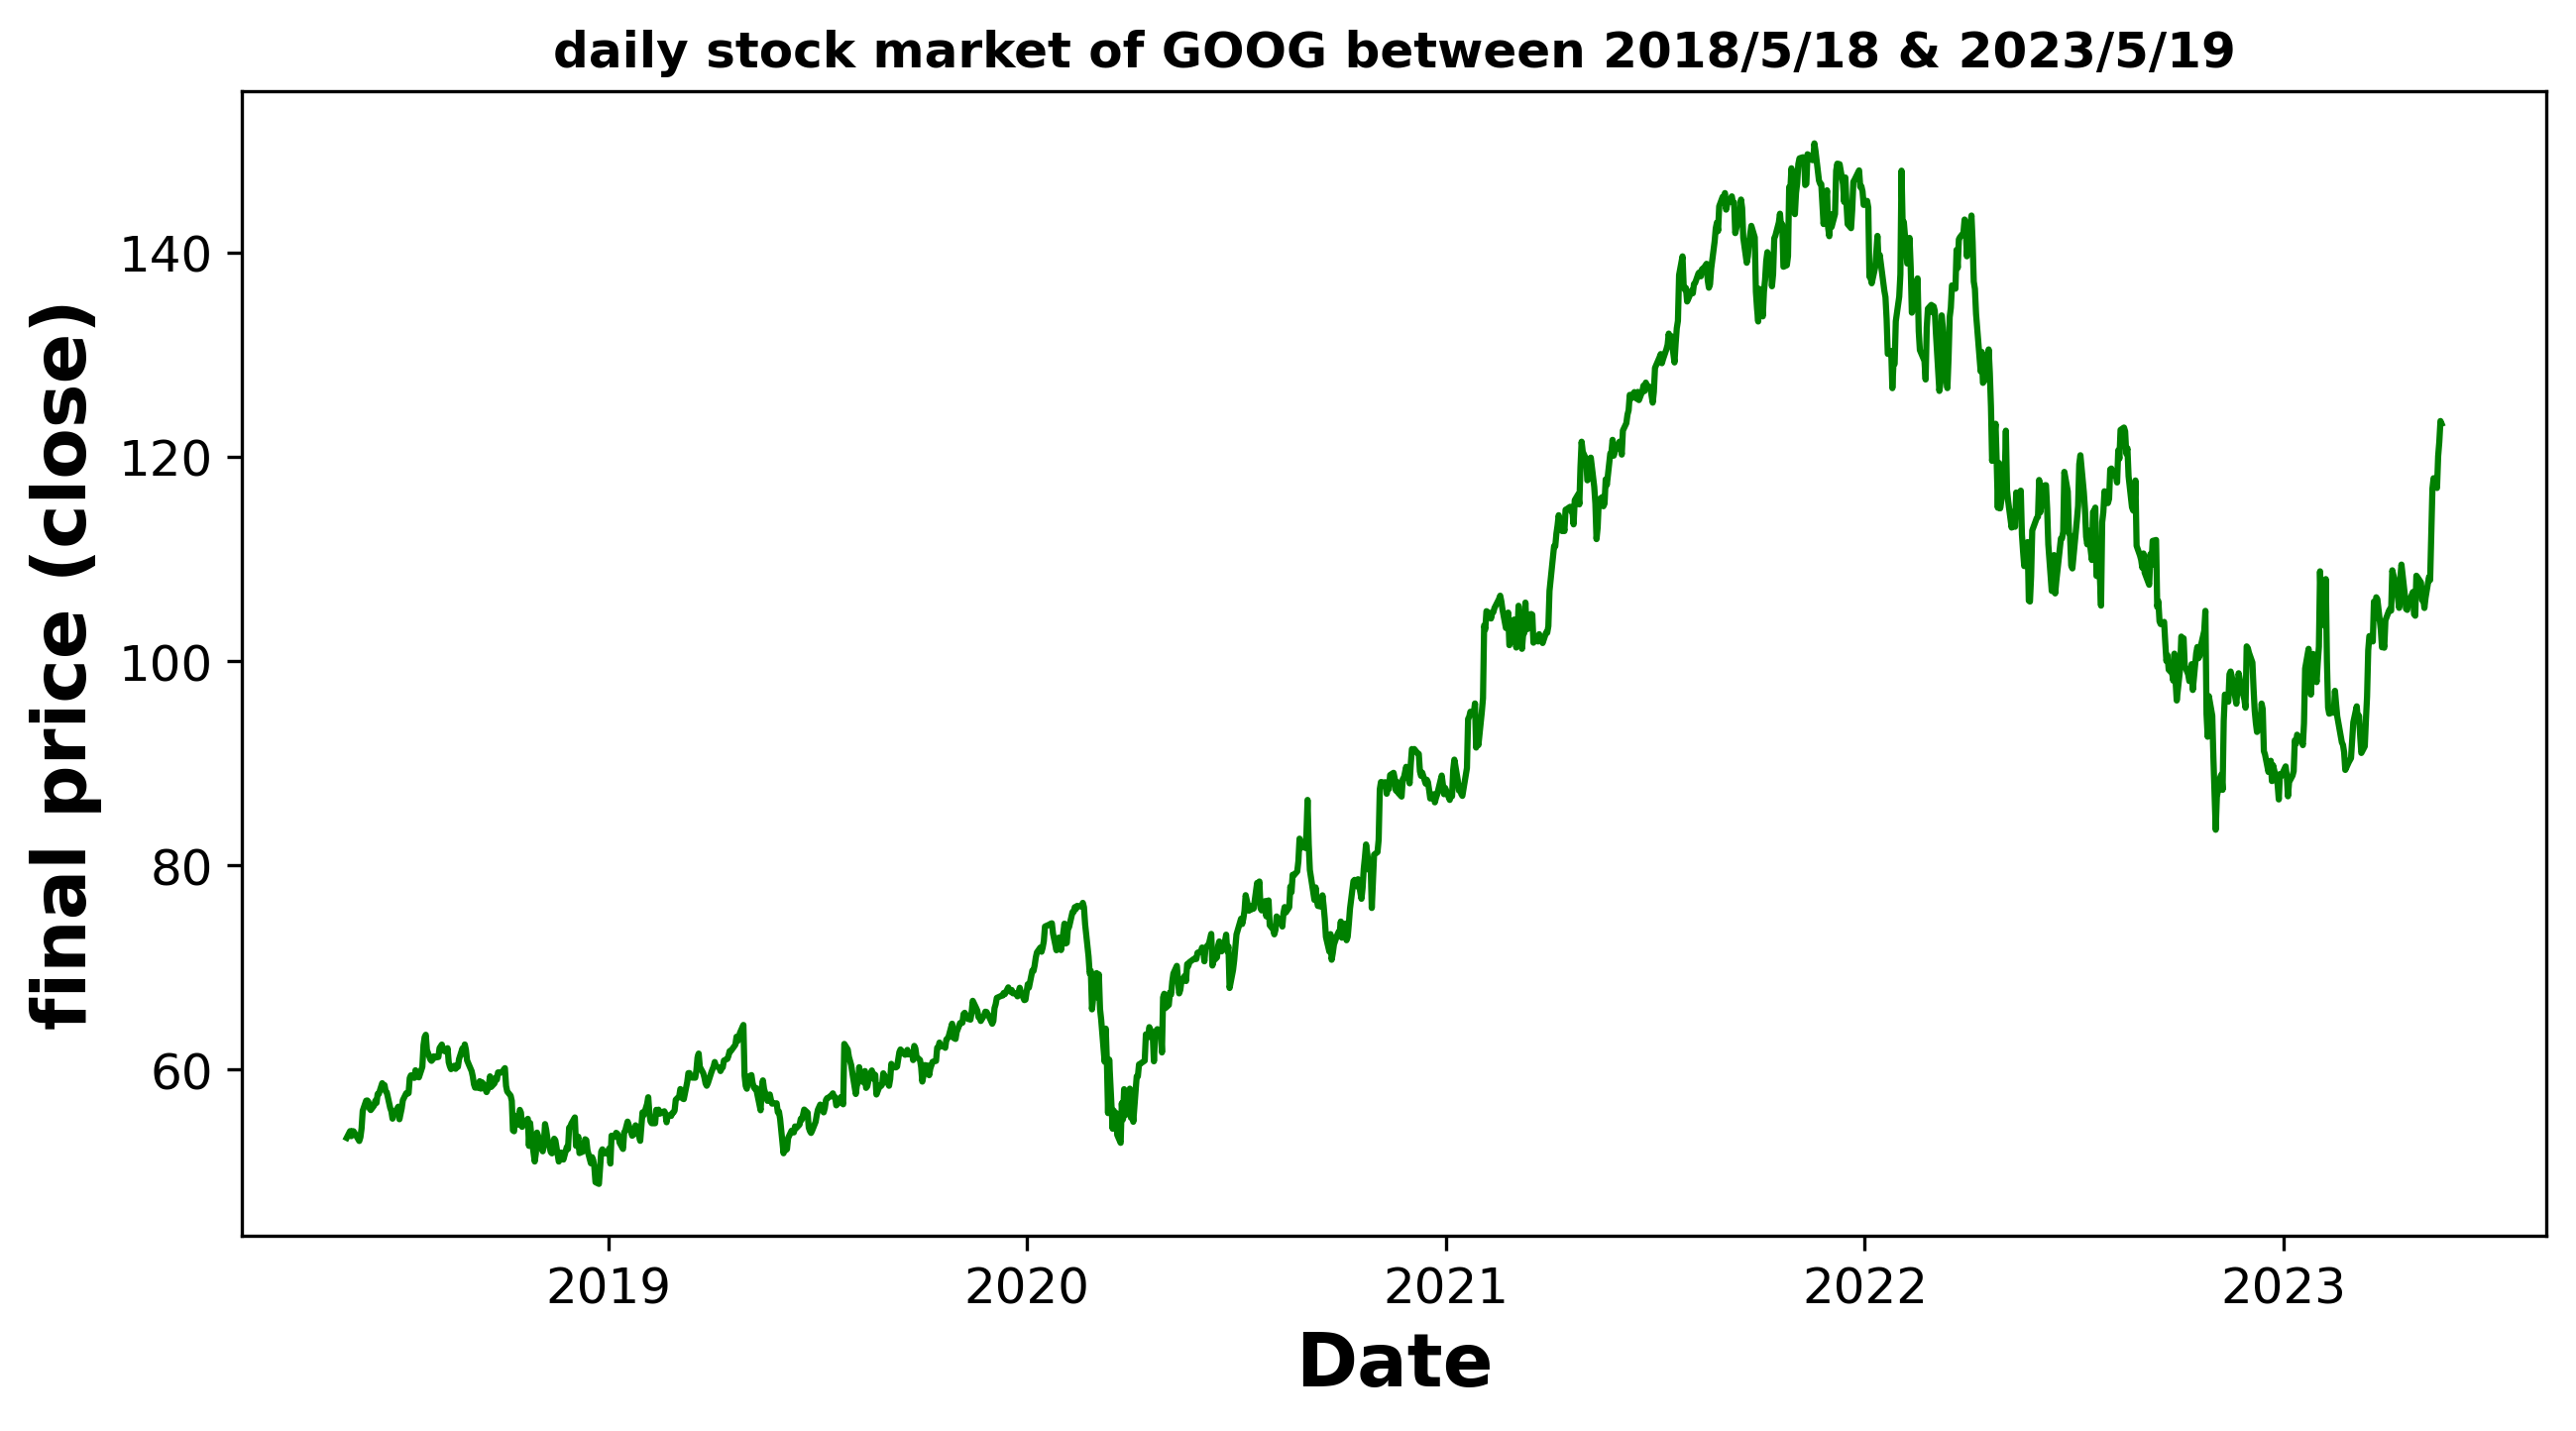

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(10,5),dpi=300)
plt.title('daily stock market of GOOG between 2018/5/18 & 2023/5/19',weight='bold',fontsize=12)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('final price (close)',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='',color='green')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Create lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df.head()

,Date,Close,Lag_1
0,2018-05-18,53.318001,NaN
1,2018-05-21,53.979000,53.318001
2,2018-05-22,53.486500,53.979000
3,2018-05-23,53.984501,53.486500
4,2018-05-24,53.962002,53.984501


In [ ]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1
0,2018-05-21,53.979000,53.318001
1,2018-05-22,53.486500,53.979000
2,2018-05-23,53.984501,53.486500
3,2018-05-24,53.962002,53.984501
4,2018-05-25,53.783001,53.962002
...,...,...,...
1254,2023-05-15,116.959999,117.919998
1255,2023-05-16,120.089996,116.959999
1256,2023-05-17,121.480003,120.089996
1257,2023-05-18,123.519997,121.480003


In [ ]:
split = int(0.8 * clean_df.shape[0])
cut_data = clean_df[split:]
cut_data

,Date,Close,Lag_1
1007,2022-05-19,110.745499,112.401001
1008,2022-05-20,109.313004,110.745499
1009,2022-05-23,111.666496,109.313004
1010,2022-05-24,105.926003,111.666496
1011,2022-05-25,105.839500,105.926003
...,...,...,...
1254,2023-05-15,116.959999,117.919998
1255,2023-05-16,120.089996,116.959999
1256,2023-05-17,121.480003,120.089996
1257,2023-05-18,123.519997,121.480003


In [ ]:
# X test
x_forecast_test=cut_data['Lag_1'].copy()
# Y test
y_forecast_test=cut_data['Close'].copy()

In [ ]:
Results=pd.DataFrame({'Date':cut_data['Date'],'Y_true':y_forecast_test,'Predict':x_forecast_test})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1007,2022-05-19,110.745499,112.401001,1.655502
1008,2022-05-20,109.313004,110.745499,1.432495
1009,2022-05-23,111.666496,109.313004,2.353492
1010,2022-05-24,105.926003,111.666496,5.740493
1011,2022-05-25,105.839500,105.926003,0.086503
...,...,...,...,...
1254,2023-05-15,116.959999,117.919998,0.959999
1255,2023-05-16,120.089996,116.959999,3.129997
1256,2023-05-17,121.480003,120.089996,1.390007
1257,2023-05-18,123.519997,121.480003,2.039994


In [ ]:
MAE=mean_absolute_error(y_forecast_test,x_forecast_test)
MSE=mean_squared_error(y_forecast_test,x_forecast_test,squared=True)
RMSE=mean_squared_error(y_forecast_test,x_forecast_test,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,x_forecast_test)
SMAPE=SMAPE_calulate(y_forecast_test,x_forecast_test)
RAE=RAE_calculate(y_forecast_test,x_forecast_test)
MRAE=MRAE_calculate(y_forecast_test,x_forecast_test)
MdRAE=MdRAE_calculate(y_forecast_test,x_forecast_test)
RSE=RSE_calculate(y_forecast_test,x_forecast_test,Root=False)
RRSE=RSE_calculate(y_forecast_test,x_forecast_test,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 1.869
MSE: 6.31
RMSE: 2.512
MAPE: 1.809 %
SMAPE: 1.809 %
RAE: 0.232
MRAE: 0.0009216549945187248
MdRAE: 0.202 bench: 103.627
RSE: 0.07
RRSE: 0.264


In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(48,24),dpi=300)
plt.title('daily stock market of GOOG between 2018/5/18 & 2023/5/19',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('final price (close)',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='',color='black',label='Actual')
plt.plot(clean_df['Date'],clean_df['Lag_1'],marker='',color='green',label='Predict')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

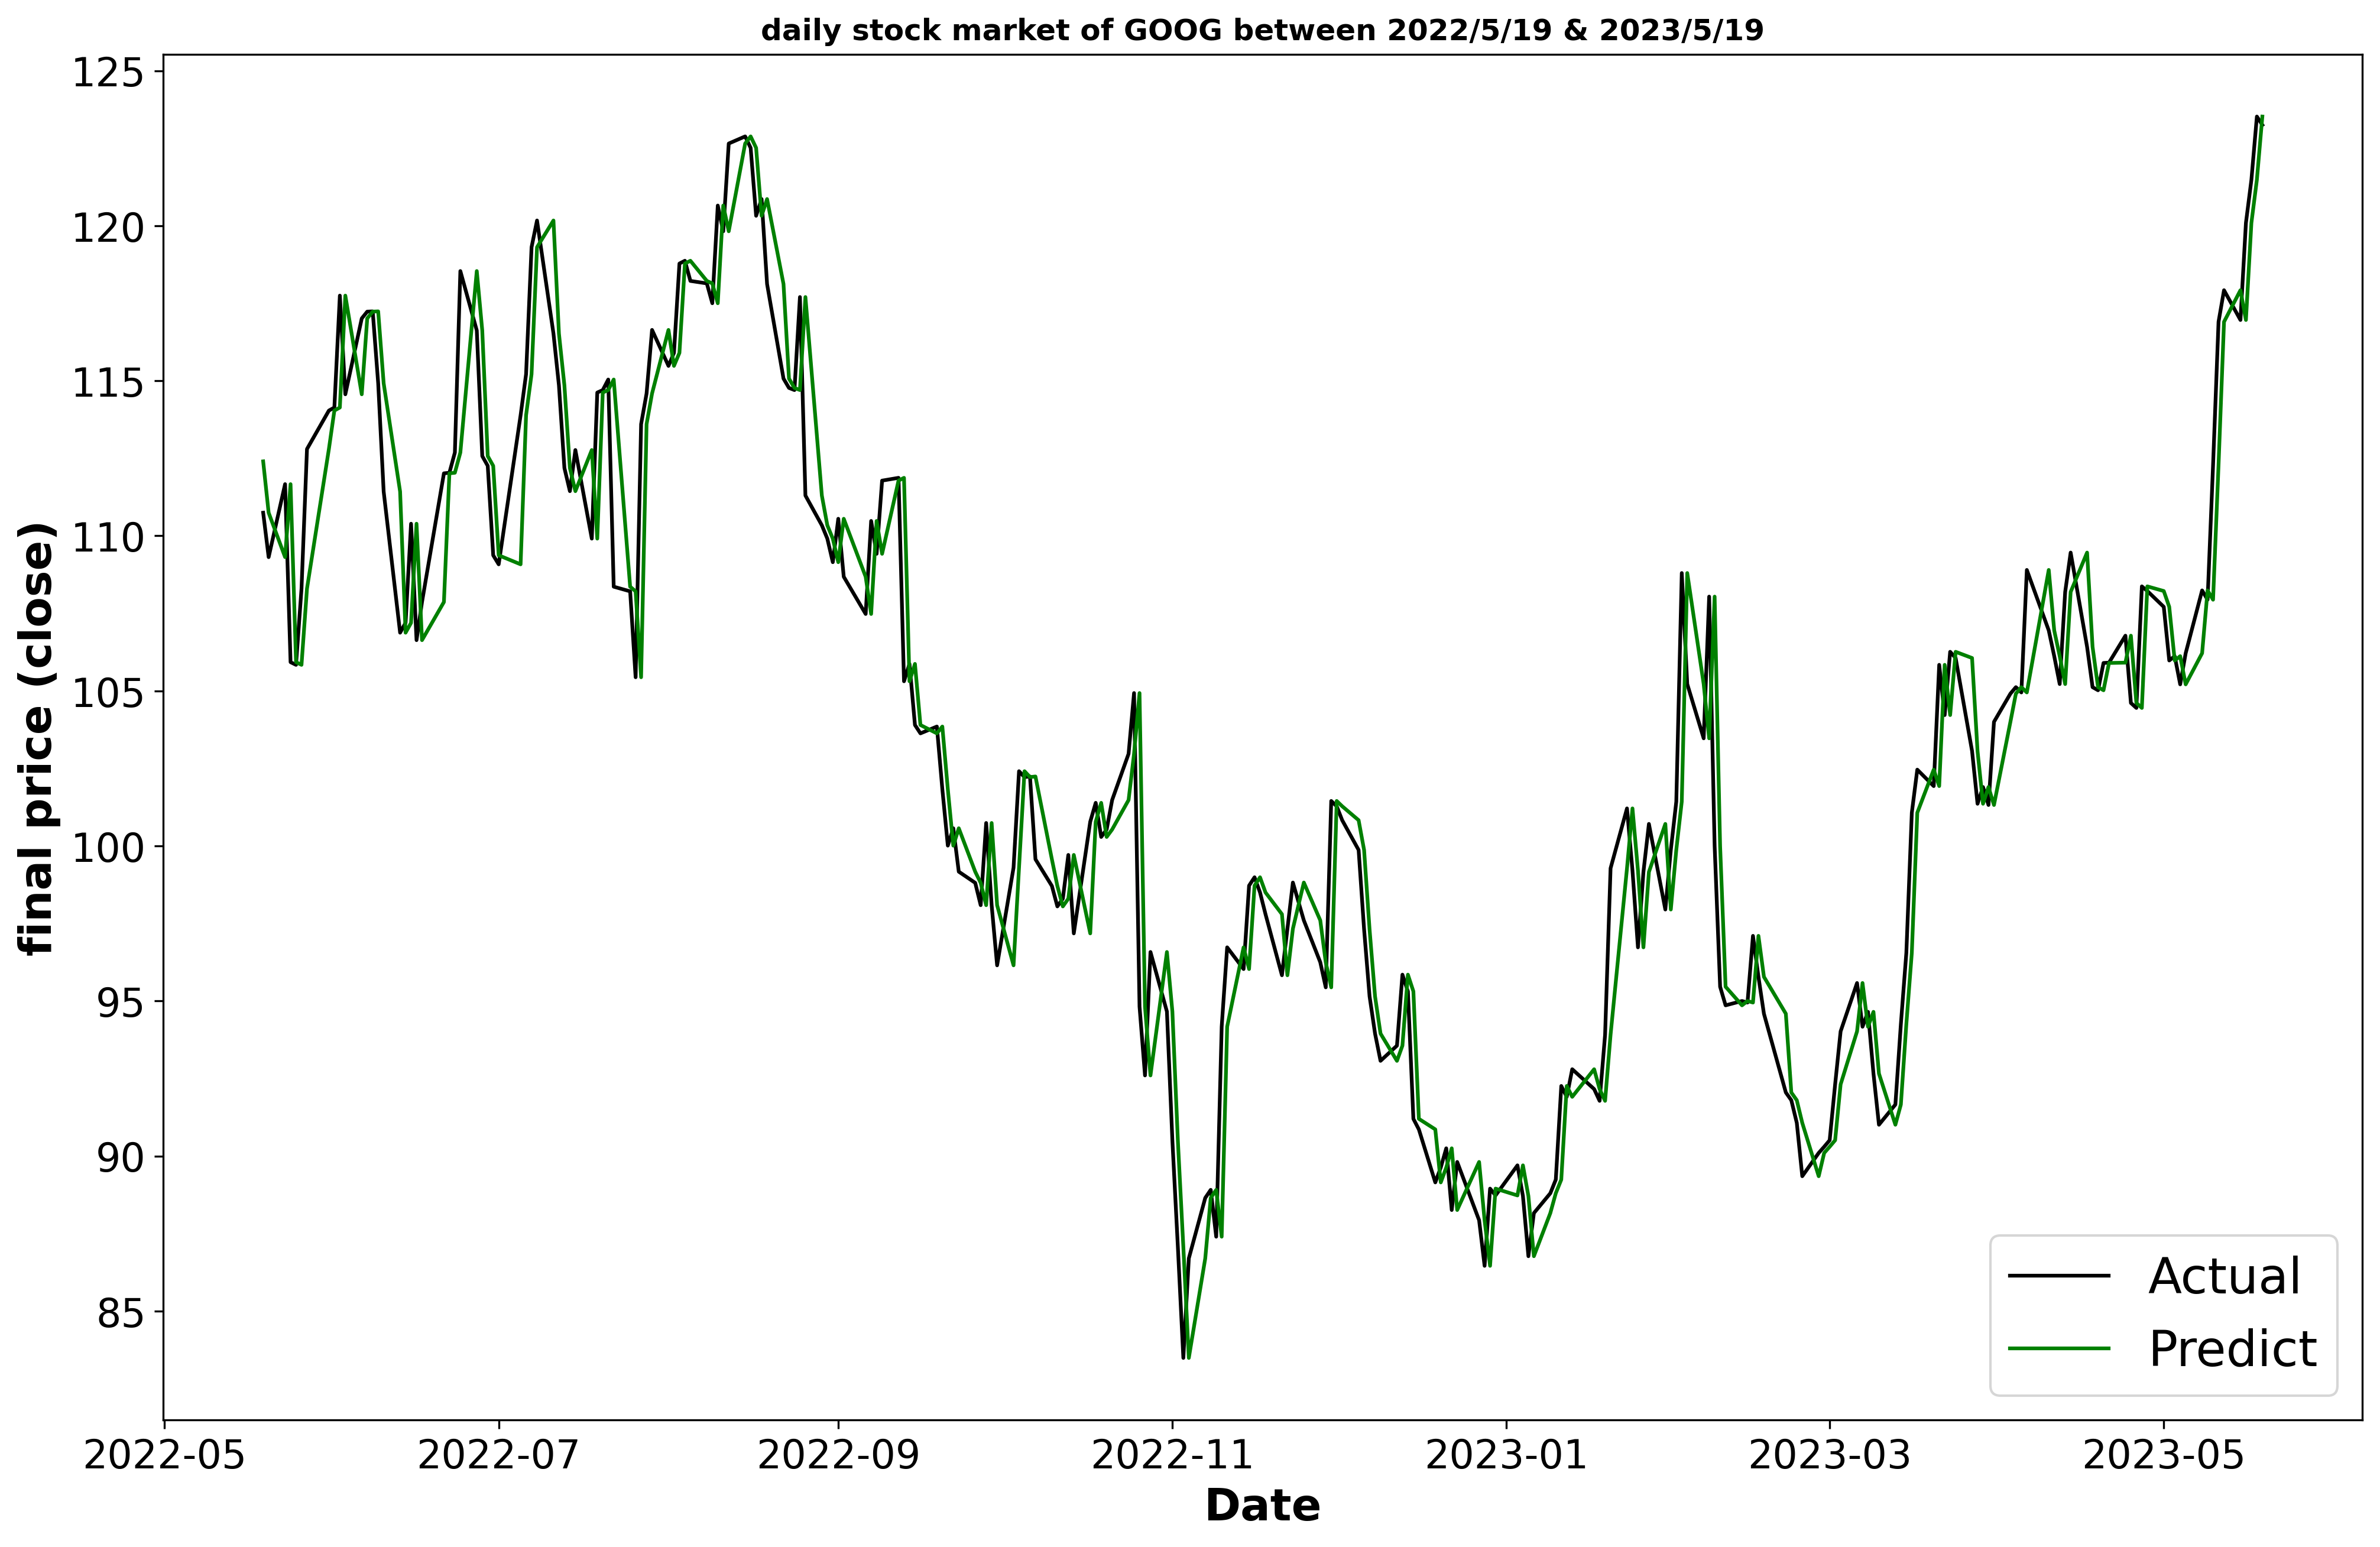

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(16,10),dpi=300)
plt.title('daily stock market of GOOG between 2022/5/19 & 2023/5/19',weight='bold',fontsize=12)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('final price (close)',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(Results['Date'],Results['Y_true'],marker='',color='black',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='',color='green',label='Predict')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

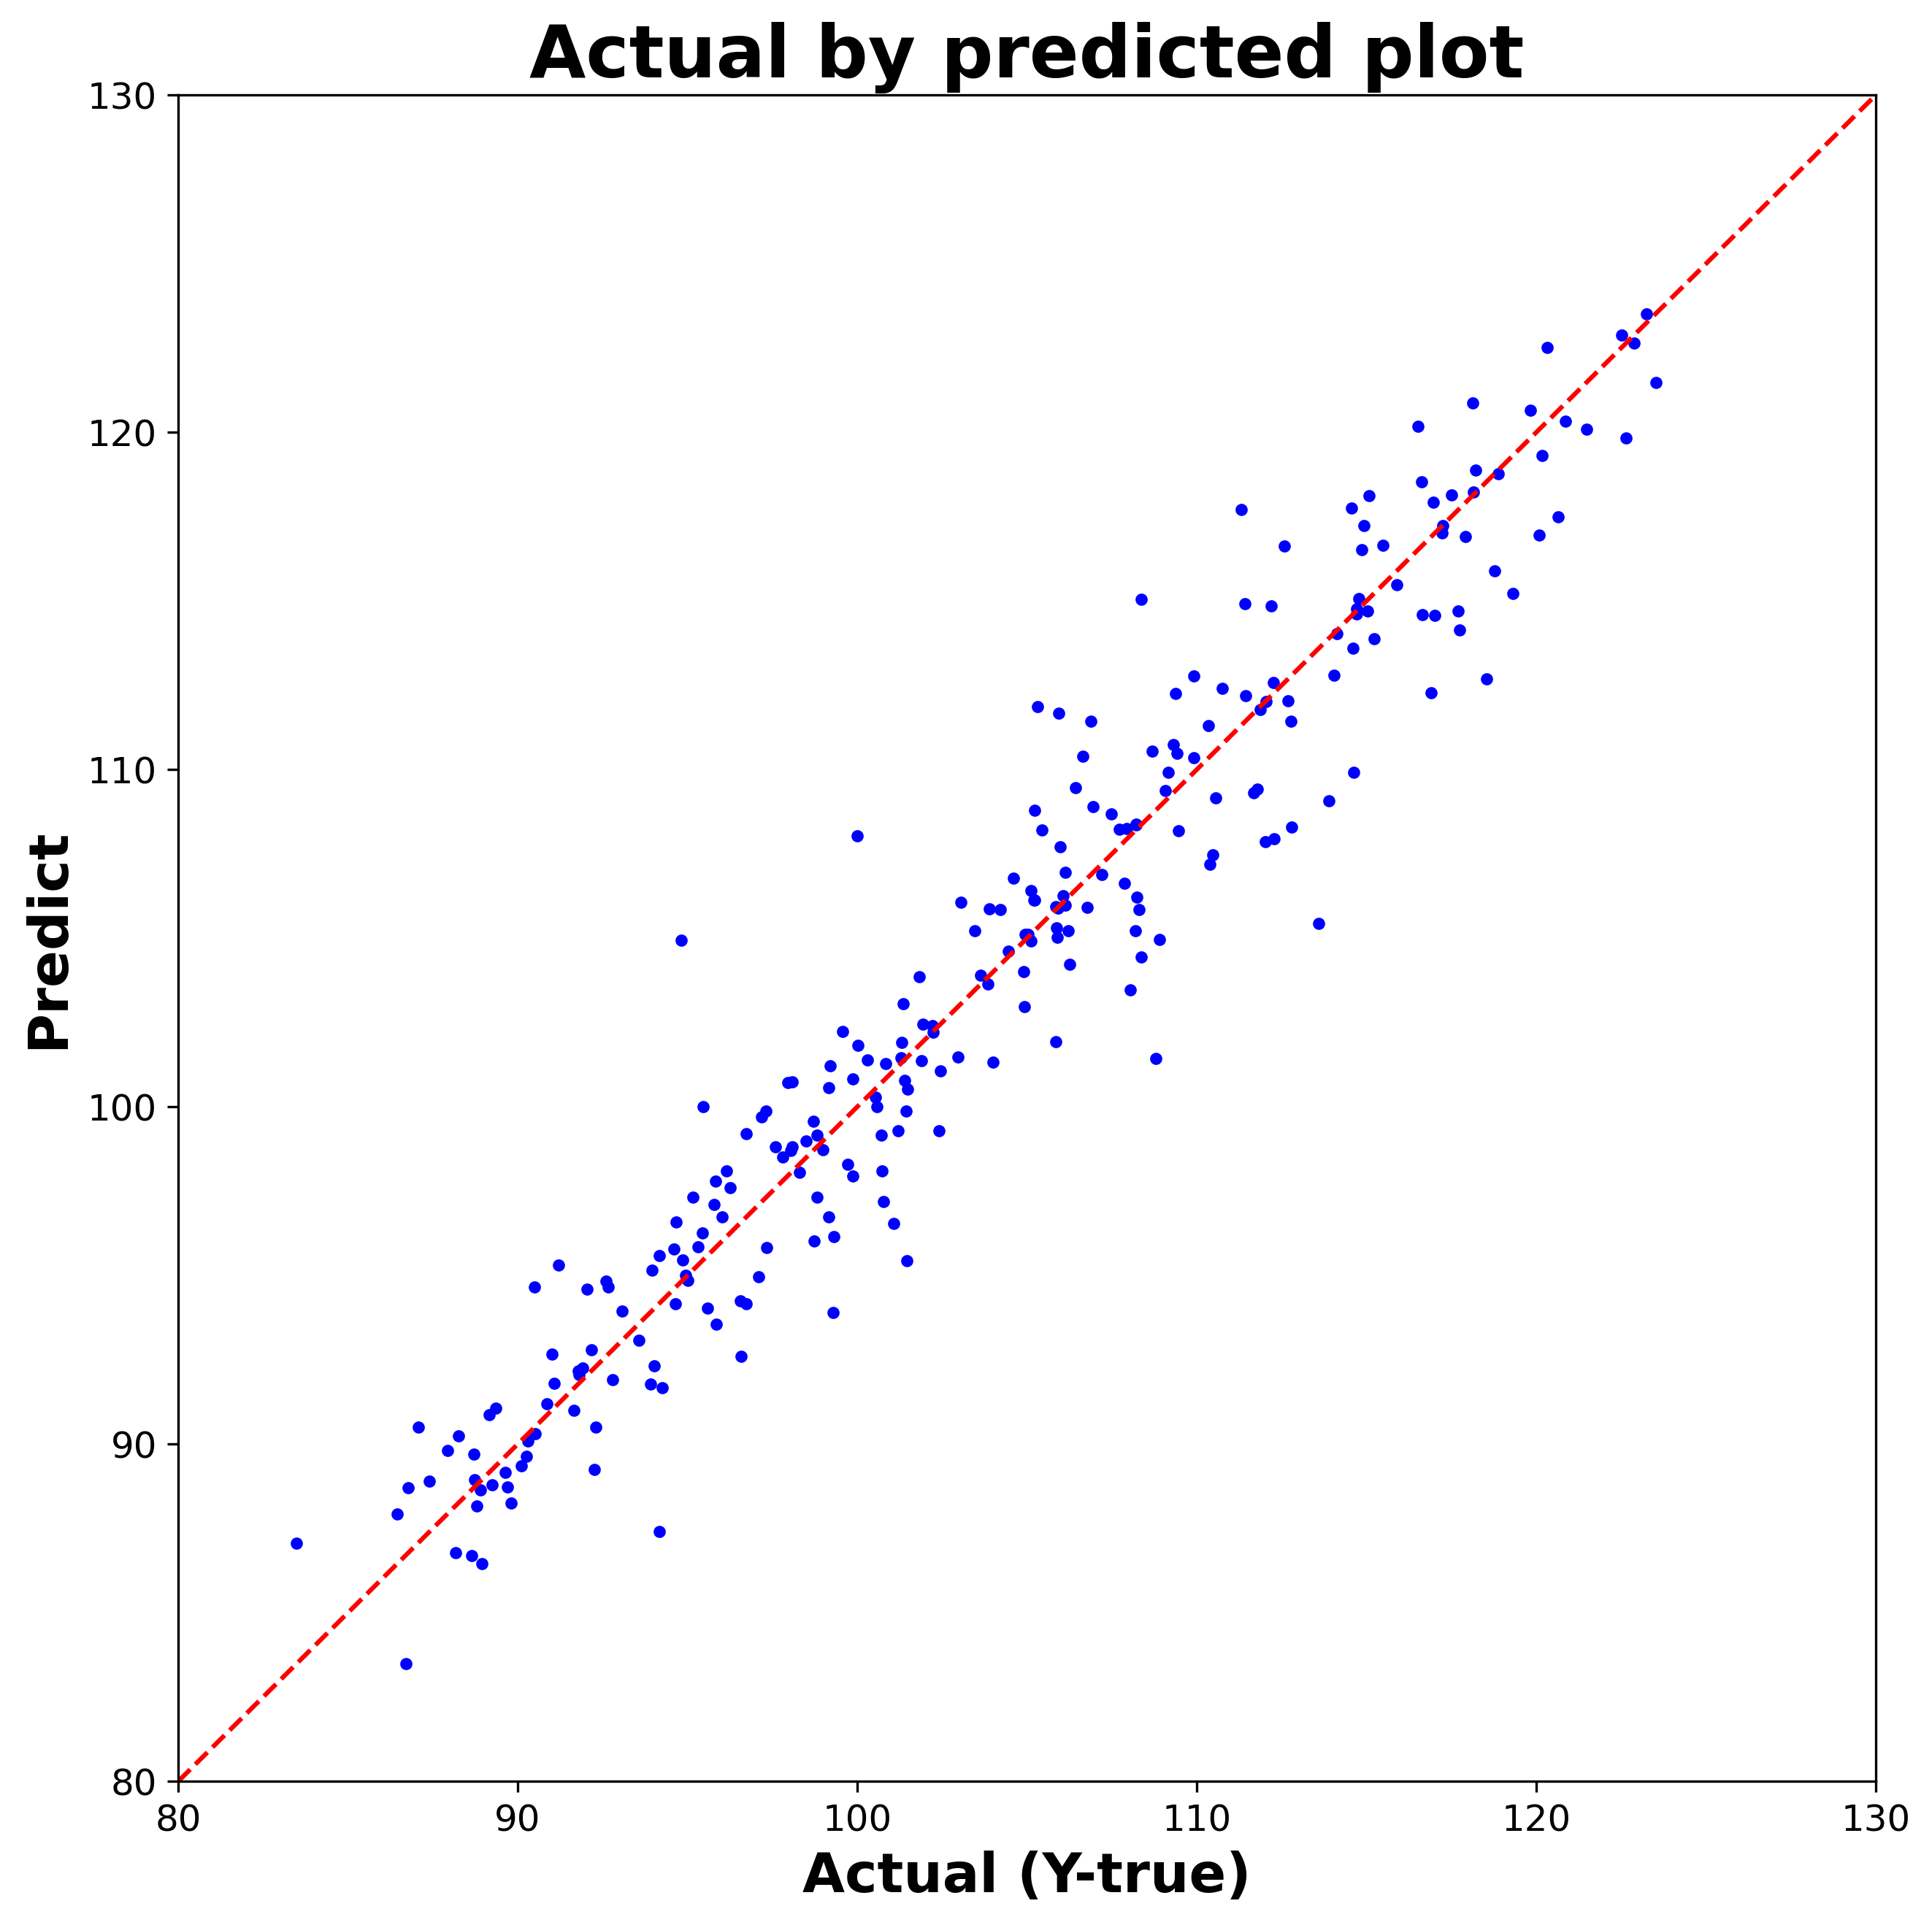

In [ ]:
# Lock the scale of axis by Y_true
max_value=100+30
min_value=0+80

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Predict',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(min_value,max_value)
plt.xlim(min_value,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()